In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
wi = np.random.uniform(-1,1,size=(4,5))
bi = np.random.uniform(-1,1,size=(1,5))
wo = np.random.uniform(-1,1,size=(5,3))
bo = np.random.uniform(-1,1,size=(1,3))

def sigmoid(x):
    s = 1 / (1 + np.exp(-x))
    return s

def sigmoid_derivative(x):
    return x * (1-x)

def tanh_derivative(x):
    return 1 - x * x

den = [1, -1.87197245084510, 0.872352556565546]
num = [0.000125945477521994, 0.000251890955043989, 0.000125945477521994]
sampleTime = 1

In [3]:
target = [1]*3000
kp = 0
ki = 0
kd = 0
x = [0, 0, 0]
de = 0
de_1 = 0
e = 0
e_1 = 0
e_2 = 0
y = 0
y_1 = 0
y_2 = 0
error_2 = 0
error_1 = 0
out = []
e_out = []
error_out = []
kp_array = []
ki_array = []
kd_array = []

# super parameter
lr = 0.6
alfa = 0.5

wi_mt_1 = np.zeros((4,5))
bi_mt_1 = np.zeros((1,5))
wo_mt_1 = np.zeros((5,3))
bo_mt_1 = np.zeros((1,3))

for i in range(1000):
    error = target[i] - y
    error_out.append(error)
    
    # BPNN_forword
    nn_inputs = np.array([target[i],y,error,1]).reshape((1,4))
    hidden_layer = np.tanh(np.dot(nn_inputs,wi) + bi)
    output_layer = sigmoid(np.dot(hidden_layer,wo) + bo)
    kp,ki,kd = output_layer[0]
    kp = kp * 10
    kp_array.append(kp)
    ki_array.append(ki)
    kd_array.append(kd)

    # PID
    x[0] = error - error_1
    x[1] = error
    x[2] = error - 2*error_1 + error_2
    de = kp * x[0] + ki * x[1] + kd * x[2]
    e = e_1 + de
    
    # limit the range of PID's output
    if e > 2:
        e = 2
    elif e < 0:
        e = 0
    e_out.append(e)

    # Transfer
    y = num[0] * e + num[1] * e_1 + num[2] * e_2 - den[1] * y_1 - den[2] * y_2
    out.append(y)

    # BPNN_backword
    # Loss = 0.5*(target[i]-y)**2
    dL_dy = y - target[i]
    dL_de = dL_dy * np.sign((y-y_1)/(de-de_1+1e-8))
    dL_dpid = np.array([dL_de * x[0] * 10,dL_de * x[1],dL_de * x[2]]).reshape((1,3))
    dL_dbo = dL_dpid * sigmoid_derivative(output_layer)
    dL_dwo = np.dot(hidden_layer.T,dL_dbo)
    dL_dhid = np.dot(dL_dbo,wo.T)
    dL_dbi = dL_dhid * tanh_derivative(hidden_layer)
    dL_dwi = np.dot(nn_inputs.T,dL_dbi)

    wi_mt = alfa * wi_mt_1 + (1-alfa) * dL_dwi
    wi = wi - lr * wi_mt
    bi_mt = alfa * bi_mt_1 + (1-alfa) * dL_dbi
    bi = bi - lr * bi_mt
    wo_mt = alfa * wo_mt_1 + (1-alfa) * dL_dwo
    wo = wo - lr * wo_mt
    bo_mt = alfa * bo_mt_1 + (1-alfa) * dL_dbo
    bo = bo - lr * bo_mt

    # update parameters
    error_2 = error_1
    error_1 = error
    
    de_1 = de
    e_2 = e_1
    e_1 = e
    y_2 = y_1
    y_1 = y

    wi_mt_1 = wi_mt
    bi_mt_1 = bi_mt
    wo_mt_1 = wo_mt
    bo_mt_1 = bo_mt

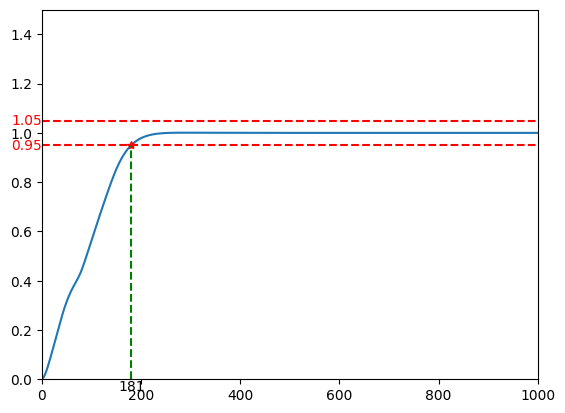

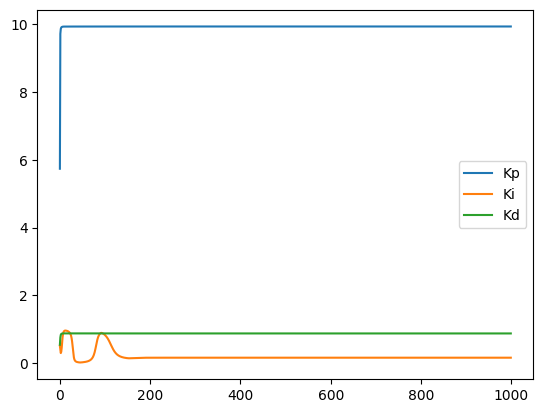

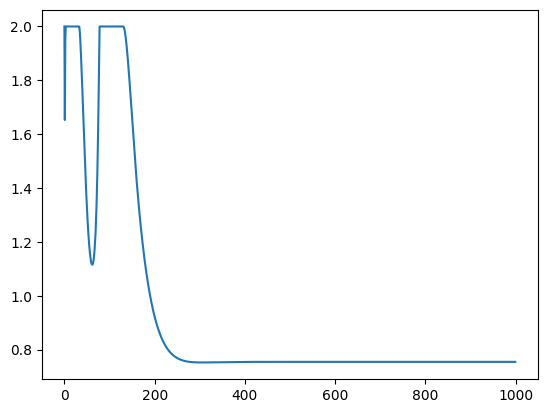

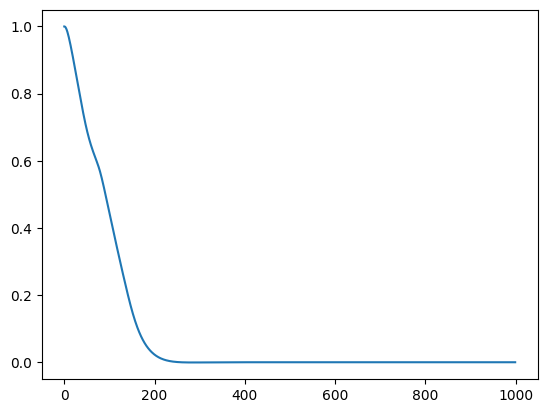

In [4]:
out_rev = list(reversed(out))

stable_range = 0.05
max_stable_num = target[0]+target[0]*stable_range
min_stable_num = target[0]-target[0]*stable_range

# 该点之后（包括该点）都在稳定区间内
out_point = 0
for number in out_rev:
    if number>max_stable_num or number<min_stable_num:
        out_point = 1000-out_rev.index(number)
        break

plt.figure()
plt.plot(out)

plt.xlim(0,1000)
plt.ylim(0,target[0]*1.5)

plt.plot(out_point, out[out_point], marker='*', color='r')
plt.vlines(out_point,0,out[out_point],linestyles='dashed',colors='g')
plt.text(out_point,0,str(out_point),color='black',verticalalignment='top', horizontalalignment='center')

stable_max = [max_stable_num]*1000
stable_min = [min_stable_num]*1000
plt.plot(stable_max,linestyle='--',color='r')
plt.plot(stable_min,linestyle='--',color='r')
plt.text(0,max_stable_num,str(max_stable_num),color='red',verticalalignment='center', horizontalalignment='right')
plt.text(0,min_stable_num,str(min_stable_num),color='red',verticalalignment='center', horizontalalignment='right')
plt.show()

plt.figure()
plt.plot(kp_array)
plt.plot(ki_array)
plt.plot(kd_array)
plt.legend(["Kp","Ki","Kd"])
plt.show()

plt.figure()
plt.plot(e_out)
plt.show()

plt.figure()
plt.plot(error_out)
plt.show()